# Maker Megan Workflow and Model Building

In [1]:
# cleaning imports
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

## Pull in Data

In [2]:
raw_data = pd.read_csv('maker_megan_visits.csv', low_memory = False)

In [3]:
raw_data.columns

Index(['ua_browser_version', 'ua_browser', 'ua_form_factor', 'ua_os_version',
       'ua_os', 'page_type', 'page_url', 'location_city', 'location_region',
       'location_country', 'referrer_host', 'referrer_name', 'referrer_path',
       'referrer_source', 'referrer_url', 'hour', 'day', 'week', 'month',
       'quarter', 'year', 'hour_day', 'day_name', 'month_name', 'visitors',
       'sessions', 'avg_duration', 'bounce_rate', 'item_in_cart',
       'reached_checkout', 'order_placed', 'total_pageviews'],
      dtype='object')

## Data Cleaning

In [4]:
#Pull in columns to work with

working_data = raw_data[['ua_browser', 'ua_form_factor', 'page_type',
       'location_country', 'referrer_source',
       'hour_day', 'day_name', 'month_name','avg_duration', 'bounce_rate', 'item_in_cart',
       'reached_checkout', 'order_placed', 'total_pageviews']].copy()

In [5]:
#Functions for data cleaning and updating columns

def location_us(string):
    if string == 'United States':
        return 'US'
    else:
        return 'Outside US'

def browser_instagram(string):
    if string == 'Instagram':
        return 'Instagram'
    else:
        return 'Other Browser'

def string_to_seconds(string):
    string = string.replace('s','')
    hour_sec = 0
    min_sec = 0
    if "h" in string:
        string_list = string.split('h')
        hour_sec = float(string_list[0])*360
        string_list = string_list[1].split('m')
        min_sec = float(string_list[0])*60
        seconds = float(string_list[1]) 
    elif "m" in string:
        string_list = string.split('m')
        min_sec = float(string_list[0])*60
        seconds = float(string_list[1]) 
    else:
        seconds = float(string)
    total_seconds = hour_sec + min_sec + seconds
    return total_seconds

def update_multiple(string):
    if string == 0 or string == 1:
        return string
    elif string == 2:
        return 1

def weekday_weekend(string):
    if string == 'Saturday' or string == 'Sunday':
        return 'Weekend'
    else:
        return 'Weekday'

def season(string):
    if string == 'December' or string == 'January' or string == 'February':
        return 'Winter'
    elif  string == 'March' or string == 'April' or string == 'May':
        return 'Spring'
    elif  string == 'June' or string == 'July' or string == 'August':
        return 'Summer'
    else:
        return 'Fall'

#Update columns
working_data['location_country'] = working_data['location_country'].apply(location_us)
working_data['ua_browser'] = working_data['ua_browser'].apply(browser_instagram)
working_data['avg_duration'] = working_data['avg_duration'].apply(string_to_seconds)
working_data['order_placed'] = working_data['order_placed'].apply(update_multiple)
working_data['day_name'] = working_data['day_name'].apply(weekday_weekend)
working_data['month_name'] = working_data['month_name'].apply(season)

In [6]:
working_data.ua_browser.unique()

array(['Instagram', 'Other Browser'], dtype=object)

In [7]:
#Add in dummies
data_with_dummies = pd.get_dummies(working_data, dummy_na=True, drop_first=True)

In [9]:
data_with_dummies.columns

Index(['hour_day', 'avg_duration', 'bounce_rate', 'item_in_cart',
       'reached_checkout', 'order_placed', 'total_pageviews',
       'ua_browser_Other Browser', 'ua_browser_nan', 'ua_form_factor_Mobile',
       'ua_form_factor_Other', 'ua_form_factor_Tablet', 'ua_form_factor_nan',
       'page_type_Checkout', 'page_type_Collection', 'page_type_Custom Page',
       'page_type_Homepage', 'page_type_Product', 'page_type_Search',
       'page_type_nan', 'location_country_US', 'location_country_nan',
       'referrer_source_Email', 'referrer_source_Search',
       'referrer_source_Social', 'referrer_source_Unknown',
       'referrer_source_nan', 'day_name_Weekend', 'day_name_nan',
       'month_name_Spring', 'month_name_Summer', 'month_name_Winter',
       'month_name_nan'],
      dtype='object')

## Look Into Potentially Helpful Features

In [10]:
#Baseline mean purchase rate

working_data.order_placed.mean()

0.03559062020600482

In [11]:
#Look at features with differences between classes

data_with_dummies.groupby('order_placed').mean()

,hour_day,avg_duration,bounce_rate,item_in_cart,reached_checkout,total_pageviews,ua_browser_Other Browser,ua_browser_nan,ua_form_factor_Mobile,ua_form_factor_Other,...,referrer_source_Search,referrer_source_Social,referrer_source_Unknown,referrer_source_nan,day_name_Weekend,day_name_nan,month_name_Spring,month_name_Summer,month_name_Winter,month_name_nan
order_placed,,,,,,,,,,,,,,,,,,,,,
0,14.183566,130.561101,0.344761,0.061128,0.016589,5.766441,0.364996,0.0,0.866927,0.006499,...,0.024088,0.147253,0.001591,0.0,0.399673,0.0,0.278735,0.088170,0.361451,0.0
1,14.995074,673.234216,0.013177,0.800493,1.002463,25.193350,0.475369,0.0,0.814039,0.000000,...,0.087438,0.110837,0.003695,0.0,0.548030,0.0,0.261084,0.118227,0.342365,0.0


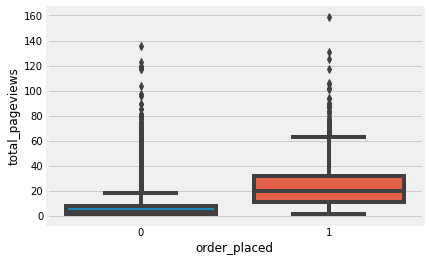

In [12]:
#Take a closer look at differences in pages views

sns.boxplot(x='order_placed', y='total_pageviews', data=data_with_dummies);

In [13]:
#Look into relationship between page_type and bounce_rate

working_data.groupby('page_type').bounce_rate.mean()

page_type
Cart           0.505208
Checkout       0.792750
Collection     0.540330
Custom Page    0.824742
Homepage       0.245596
Product        0.749494
Search         0.594595
Name: bounce_rate, dtype: float64

## Begin Model Building

In [14]:
#Set features and targets

features = ['hour_day', 'avg_duration', 'bounce_rate', 'item_in_cart',
       'reached_checkout', 'total_pageviews',
       'ua_browser_Other Browser', 'ua_browser_nan', 'ua_form_factor_Mobile',
       'ua_form_factor_Other', 'ua_form_factor_Tablet', 'ua_form_factor_nan',
       'page_type_Checkout', 'page_type_Collection', 'page_type_Custom Page',
       'page_type_Homepage', 'page_type_Product', 'page_type_Search',
       'page_type_nan', 'location_country_US', 'location_country_nan',
       'referrer_source_Email', 'referrer_source_Search',
       'referrer_source_Social', 'referrer_source_Unknown',
       'referrer_source_nan', 'day_name_Weekend', 'day_name_nan',
       'month_name_Spring', 'month_name_Summer', 'month_name_Winter',
       'month_name_nan']
target = 'order_placed'

X = data_with_dummies[features]
y = data_with_dummies[target]

In [15]:
#Create hold out set for validation/split into train & test

X_train_test, X_validation, y_train_test, y_validation = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=.2, random_state=42, stratify=y_train_test)

In [16]:
#Function to help with running models 

def test_score(train_features, train_target, test_features, test_target):
    lm = LogisticRegression(class_weight='balanced', solver='liblinear')
    lm.fit(train_features, train_target)
    y_preds = lm.predict(test_features)
    print('Accuracy Score: ', lm.score(test_features, test_target))
    print('Confusion Matrix: \n', confusion_matrix(test_target, y_preds, labels=[0, 1]))
    print('Intercept: ', lm.intercept_)
    coef_list = lm.coef_.tolist()
    coef_with_names = list(zip(train_features, coef_list[0]))
    for element in coef_with_names:
        print(element)
    print('F Beta Score: ', fbeta_score(test_target, y_preds, beta=0.5))
    return coef_with_names

In [17]:
#Model 1 - start with basic features determined by EDA

features1 = ['total_pageviews','avg_duration']

test_score(X_train[features1], y_train, X_test[features1], y_test)

Accuracy Score:  0.8663379895918927
Confusion Matrix: 
 [[3071  450]
 [  38   92]]
Intercept:  [-2.06808544]
('total_pageviews', 0.16066183309534593)
('avg_duration', 0.0006016461260186773)
F Beta Score:  0.20017406440382945


[('total_pageviews', 0.16066183309534593),
 ('avg_duration', 0.0006016461260186773)]

In [18]:
#Model 2 - add all features

features2 = features #use all features

test_score(X_train[features2], y_train, X_test[features2], y_test)

Accuracy Score:  0.9832922486989866
Confusion Matrix: 
 [[3460   61]
 [   0  130]]
Intercept:  [-5.48916873]
('hour_day', 0.006538228036593245)
('avg_duration', 8.977547353064948e-05)
('bounce_rate', -1.3345648849745262)
('item_in_cart', -0.05713585352738769)
('reached_checkout', 9.614148720334262)
('total_pageviews', 0.021519021944444303)
('ua_browser_Other Browser', 0.12368921143407015)
('ua_browser_nan', 0.0)
('ua_form_factor_Mobile', -0.5804451292765801)
('ua_form_factor_Other', -0.11666273028031884)
('ua_form_factor_Tablet', 0.1550928743335345)
('ua_form_factor_nan', 0.0)
('page_type_Checkout', -0.13975653788732237)
('page_type_Collection', -1.236469692433312)
('page_type_Custom Page', -0.11403876443828673)
('page_type_Homepage', -1.568176233335703)
('page_type_Product', -1.0023373167584153)
('page_type_Search', -0.06672583163074089)
('page_type_nan', -0.05161350004402309)
('location_country_US', 1.2292937922557983)
('location_country_nan', 0.0)
('referrer_source_Email', -0.001092

[('hour_day', 0.006538228036593245),
 ('avg_duration', 8.977547353064948e-05),
 ('bounce_rate', -1.3345648849745262),
 ('item_in_cart', -0.05713585352738769),
 ('reached_checkout', 9.614148720334262),
 ('total_pageviews', 0.021519021944444303),
 ('ua_browser_Other Browser', 0.12368921143407015),
 ('ua_browser_nan', 0.0),
 ('ua_form_factor_Mobile', -0.5804451292765801),
 ('ua_form_factor_Other', -0.11666273028031884),
 ('ua_form_factor_Tablet', 0.1550928743335345),
 ('ua_form_factor_nan', 0.0),
 ('page_type_Checkout', -0.13975653788732237),
 ('page_type_Collection', -1.236469692433312),
 ('page_type_Custom Page', -0.11403876443828673),
 ('page_type_Homepage', -1.568176233335703),
 ('page_type_Product', -1.0023373167584153),
 ('page_type_Search', -0.06672583163074089),
 ('page_type_nan', -0.05161350004402309),
 ('location_country_US', 1.2292937922557983),
 ('location_country_nan', 0.0),
 ('referrer_source_Email', -0.0010923353502862226),
 ('referrer_source_Search', 0.013595810065459579),

In [19]:
#Model 3 - scale data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

features3 = features #use all features

test_score(X_train_scaled, y_train, X_test_scaled, y_test)

Accuracy Score:  0.9832922486989866
Confusion Matrix: 
 [[3460   61]
 [   0  130]]
Intercept:  [-6.70446788]
(array([ 0.12759013, -0.1926438 , -0.70980179, -0.31118519, -0.23271028,
        0.05211943, -0.77138863,  0.        ,  0.39492465, -0.07652194,
       -0.08987702,  0.        , -0.184369  , -0.31709657, -0.06530231,
        0.52978971, -0.28318776, -0.04223596, -0.03206842,  0.42378394,
        0.        , -0.00827606, -0.16566089, -0.4082646 , -0.04141435,
        0.        ,  1.21767854,  0.        , -0.62061477, -0.30971655,
        1.32610295,  0.        ]), 0.17243261775737478)
(array([-2.20731569,  0.15361923, -0.70980179, -0.31118519, -0.23271028,
        0.37335027,  1.29636342,  0.        ,  0.39492465, -0.07652194,
       -0.08987702,  0.        , -0.184369  , -0.31709657, -0.06530231,
        0.52978971, -0.28318776, -0.04223596, -0.03206842,  0.42378394,
        0.        , -0.00827606, -0.16566089, -0.4082646 , -0.04141435,
        0.        , -0.82123481,  0.     

[(array([ 0.12759013, -0.1926438 , -0.70980179, -0.31118519, -0.23271028,
          0.05211943, -0.77138863,  0.        ,  0.39492465, -0.07652194,
         -0.08987702,  0.        , -0.184369  , -0.31709657, -0.06530231,
          0.52978971, -0.28318776, -0.04223596, -0.03206842,  0.42378394,
          0.        , -0.00827606, -0.16566089, -0.4082646 , -0.04141435,
          0.        ,  1.21767854,  0.        , -0.62061477, -0.30971655,
          1.32610295,  0.        ]),
  0.17243261775737478),
 (array([-2.20731569,  0.15361923, -0.70980179, -0.31118519, -0.23271028,
          0.37335027,  1.29636342,  0.        ,  0.39492465, -0.07652194,
         -0.08987702,  0.        , -0.184369  , -0.31709657, -0.06530231,
          0.52978971, -0.28318776, -0.04223596, -0.03206842,  0.42378394,
          0.        , -0.00827606, -0.16566089, -0.4082646 , -0.04141435,
          0.        , -0.82123481,  0.        ,  1.6113055 , -0.30971655,
         -0.75408927,  0.        ]),
  0.0338326223

In [20]:
#Grid search for best parameters

param_grid = {'penalty' : ['l1', 'l2'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

#Create grid search object

lm = LogisticRegression(class_weight='balanced', solver='liblinear')

grid_search = GridSearchCV(lm, param_grid = param_grid, cv = 5, verbose=True, scoring='f1')

#Fit on data

grid_search.fit(X_train, y_train)

#Look at results

grid_search_df = pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [134]:
grid_search_df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.019478,0.001623,0.002142,0.000098,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",0.793893,0.848980,0.800000,0.815686,0.825397,0.816791,0.019584,1
4,0.030891,0.002305,0.002041,0.000036,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",0.793893,0.848980,0.800000,0.815686,0.825397,0.816791,0.019584,1
5,0.044884,0.002173,0.002128,0.000122,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.793893,0.848980,0.800000,0.815686,0.825397,0.816791,0.019584,1
6,0.059249,0.007297,0.002101,0.000056,1,l1,"{'C': 1, 'penalty': 'l1'}",0.793893,0.848980,0.800000,0.815686,0.825397,0.816791,0.019584,1
7,0.049527,0.002547,0.002108,0.000047,1,l2,"{'C': 1, 'penalty': 'l2'}",0.793893,0.848980,0.800000,0.815686,0.825397,0.816791,0.019584,1
8,0.097527,0.028637,0.004065,0.003964,10,l1,"{'C': 10, 'penalty': 'l1'}",0.793893,0.848980,0.800000,0.815686,0.825397,0.816791,0.019584,1
9,0.056969,0.003828,0.002277,0.000210,10,l2,"{'C': 10, 'penalty': 'l2'}",0.793893,0.848980,0.800000,0.815686,0.825397,0.816791,0.019584,1
10,0.142423,0.030623,0.002171,0.000178,100,l1,"{'C': 100, 'penalty': 'l1'}",0.793893,0.848980,0.800000,0.815686,0.825397,0.816791,0.019584,1
11,0.057184,0.004283,0.002266,0.000111,100,l2,"{'C': 100, 'penalty': 'l2'}",0.793893,0.848980,0.800000,0.815686,0.825397,0.816791,0.019584,1
12,0.145152,0.028589,0.002108,0.000032,1000,l1,"{'C': 1000, 'penalty': 'l1'}",0.793893,0.848980,0.800000,0.815686,0.825397,0.816791,0.019584,1


In [21]:
#Model 4 - grid search parameters

lm = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l2',C=0.01)
lm.fit(X_train, y_train)
y_preds = lm.predict(X_test)
print('Accuracy Score: ', lm.score(X_test, y_test))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_preds, labels=[0, 1]))
print('Intercept: ', lm.intercept_)
coef_list = lm.coef_.tolist()
coef_with_names = list(zip( X_train, coef_list[0]))
for element in coef_with_names:
    print(element)
print('F Beta Score: ', fbeta_score(y_test, y_preds, beta=0.5))

Accuracy Score:  0.9805532730758696
Confusion Matrix: 
 [[3450   71]
 [   0  130]]
Intercept:  [-1.01078088]
('hour_day', -0.0359608206358102)
('avg_duration', 0.00018902762125326105)
('bounce_rate', -0.767321501406313)
('item_in_cart', 0.9260060036282493)
('reached_checkout', 3.9626924468133717)
('total_pageviews', 0.03763916033828587)
('ua_browser_Other Browser', -0.09713513770945427)
('ua_browser_nan', 0.0)
('ua_form_factor_Mobile', -0.4753322346802985)
('ua_form_factor_Other', -0.036616588791128564)
('ua_form_factor_Tablet', -0.02394966327192327)
('ua_form_factor_nan', 0.0)
('page_type_Checkout', 0.1785417378742847)
('page_type_Collection', -0.3164267795392017)
('page_type_Custom Page', -0.022275208968233505)
('page_type_Homepage', -0.6821440344210675)
('page_type_Product', -0.17813392517461227)
('page_type_Search', -0.011092204824162658)
('page_type_nan', -0.006803009084692487)
('location_country_US', -0.19708772696547588)
('location_country_nan', 0.0)
('referrer_source_Email', -0

In [22]:
#Model 5 - different features

features5 = ['bounce_rate', 'item_in_cart',
       'reached_checkout', 'total_pageviews',
       'page_type_Checkout', 'page_type_Collection', 'page_type_Custom Page', 'page_type_Homepage',
       'page_type_Product', 'page_type_Search', 'page_type_nan',
       'location_country_nan', 'location_country_US',
       'day_name_Weekend',
       'day_name_nan', 'month_name_Spring', 'month_name_Summer',
       'month_name_Winter', 'month_name_nan']

test_score(X_train[features5], y_train, X_test[features5], y_test)

Accuracy Score:  0.9832922486989866
Confusion Matrix: 
 [[3460   61]
 [   0  130]]
Intercept:  [-5.7776528]
('bounce_rate', -1.1742378474439854)
('item_in_cart', -0.022076216728949646)
('reached_checkout', 9.599914013725558)
('total_pageviews', 0.024376063359225507)
('page_type_Checkout', -0.08835239369612584)
('page_type_Collection', -1.1226713695508734)
('page_type_Custom Page', -0.09193639585335164)
('page_type_Homepage', -1.5123375776641796)
('page_type_Product', -0.8183277542229362)
('page_type_Search', -0.07971449684955648)
('page_type_nan', -0.0547672951553092)
('location_country_nan', 0.0)
('location_country_US', 0.9982365932686303)
('day_name_Weekend', 0.8291389353332086)
('day_name_nan', 0.0)
('month_name_Spring', -0.20162577840095472)
('month_name_Summer', 0.5385682351046917)
('month_name_Winter', -0.6419959736333286)
('month_name_nan', 0.0)
F Beta Score:  0.7270693512304252


[('bounce_rate', -1.1742378474439854),
 ('item_in_cart', -0.022076216728949646),
 ('reached_checkout', 9.599914013725558),
 ('total_pageviews', 0.024376063359225507),
 ('page_type_Checkout', -0.08835239369612584),
 ('page_type_Collection', -1.1226713695508734),
 ('page_type_Custom Page', -0.09193639585335164),
 ('page_type_Homepage', -1.5123375776641796),
 ('page_type_Product', -0.8183277542229362),
 ('page_type_Search', -0.07971449684955648),
 ('page_type_nan', -0.0547672951553092),
 ('location_country_nan', 0.0),
 ('location_country_US', 0.9982365932686303),
 ('day_name_Weekend', 0.8291389353332086),
 ('day_name_nan', 0.0),
 ('month_name_Spring', -0.20162577840095472),
 ('month_name_Summer', 0.5385682351046917),
 ('month_name_Winter', -0.6419959736333286),
 ('month_name_nan', 0.0)]

## Cross Validation

In [24]:
#Model 5
lm5 = LogisticRegression(class_weight='balanced', solver='liblinear')
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
results = cross_val_score(lm5, X_train_test[features5], y_train_test, cv=kf, scoring='f1')
print(results, 'Mean: ', results.mean())

[0.79444444 0.82274247 0.80769231 0.81506849 0.8373494 ] Mean:  0.8154594235588373


## Final Testing

In [25]:
#Test using all training data on validation set

final_model_features = test_score(X_train_test[features5], y_train_test, X_validation[features5], y_validation)

Accuracy Score:  0.9853166776243699
Confusion Matrix: 
 [[4334   67]
 [   0  162]]
Intercept:  [-6.09731464]
('bounce_rate', -1.0794532109842474)
('item_in_cart', 0.0024259973612547306)
('reached_checkout', 9.769862490494612)
('total_pageviews', 0.024699910249594864)
('page_type_Checkout', -0.2241048548467022)
('page_type_Collection', -0.9023701554234018)
('page_type_Custom Page', -0.07516776513477508)
('page_type_Homepage', -1.3294243081799784)
('page_type_Product', -0.8523534932714247)
('page_type_Search', -0.5306323782917749)
('page_type_nan', -0.0413559210117781)
('location_country_nan', 0.0)
('location_country_US', 0.9105800625069713)
('day_name_Weekend', 0.8140402303437076)
('day_name_nan', 0.0)
('month_name_Spring', -0.20663582157134688)
('month_name_Summer', 0.603327258410781)
('month_name_Winter', -0.4781607273405877)
('month_name_nan', 0.0)
F Beta Score:  0.7513914656771801


In [26]:
#Save beta coefficients to table

final_model_features_df = pd.DataFrame(final_model_features, columns=['Feature', 'Beta Coefficients'])
final_model_features_df.sort_values(by='Beta Coefficients')

,Feature,Beta Coefficients
7,page_type_Homepage,-1.329424
0,bounce_rate,-1.079453
5,page_type_Collection,-0.902370
8,page_type_Product,-0.852353
9,page_type_Search,-0.530632
17,month_name_Winter,-0.478161
4,page_type_Checkout,-0.224105
15,month_name_Spring,-0.206636
6,page_type_Custom Page,-0.075168
10,page_type_nan,-0.041356


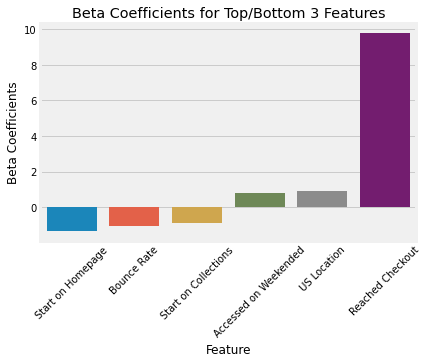

In [29]:
#Create chart for beta coefficients

importance_mask = (final_model_features_df['Beta Coefficients']>0.7) | (final_model_features_df['Beta Coefficients']< -0.90)
sns.barplot(x='Feature',y='Beta Coefficients', data=final_model_features_df[importance_mask].sort_values(by='Beta Coefficients'))
plt.title('Beta Coefficients for Top/Bottom 3 Features')
labels = ['Start on Homepage','Bounce Rate','Start on Collections','Accessed on Weekended','US Location', 'Reached Checkout' ]
plt.xticks(range(0,6), labels, rotation=45);